In [1]:
import av
from video import Video
path = '../videos/SOX5yA1l24A.mp4'

In [2]:
test_object = Video(path)

List of available streams:
{'video': [<av.VideoStream #0 h264, yuv420p 340x256 at 0x7f4019bb66e0>], 'audio': [<av.AudioStream #1 aac at 48000Hz, mono, fltp at 0x7f3f940bf0c0>]}
../videos/SOX5yA1l24A.mp4 
 	 default stream:  <av.VideoStream #0 h264, yuv420p 340x256 at 0x7f4019bb66e0>


In [3]:
test_object.peak(4.78, any_frame=True)

This is going to be very slow
Empirical_next_delta: 0.03336666666666677 
 Estimated_next_delta: 0.03336666666666677 
 Estimated_next 4.671333333333333 
 Current_ts 4.637966666666666 
 Requested_ts 4.78 

Empirical_next_delta: 0.03336666666666677 
 Estimated_next_delta: 0.03336666666666677 
 Estimated_next 4.7047 
 Current_ts 4.671333333333333 
 Requested_ts 4.78 

Empirical_next_delta: 0.03336666666666677 
 Estimated_next_delta: 0.03336666666666677 
 Estimated_next 4.738066666666667 
 Current_ts 4.7047 
 Requested_ts 4.78 

Empirical_next_delta: 0.03336666666666677 
 Estimated_next_delta: 0.03336666666666677 
 Estimated_next 4.771433333333333 
 Current_ts 4.738066666666667 
 Requested_ts 4.78 

Empirical_next_delta: 0.03336666666666677 
 Estimated_next_delta: 0.03336666666666677 
 Estimated_next 4.8048 
 Current_ts 4.771433333333333 
 Requested_ts 4.78 



NameError: name 'container' is not defined

In [ ]:
test_object.seek(4.78, any_frame=True)


# Implementing rudimentary read video function

### That supports most of the functionality from the current TV

In [1]:
import torch
import torchvision
torchvision.set_video_backend("pyav")
def get_tv(path):
    vframes, aframes, _ = torchvision.io.read_video(path, pts_unit="sec")
    return vframes.size(), aframes.size()

sa, sb = get_tv(path)
sizes = f"Expected sizes: {sa}, {sb}"

NameError: name 'path' is not defined

In [ ]:
import torch
from torchvision import transforms as t


def read_video(vid, start=0, end=None, height=-1, width=-1, read_video=True, read_audio=True):
    if not isinstance(vid, Video):
        vid = Video(path)
    
    # safety checks - basic stuff
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end_pts should be larger than start_pts, got "
            "start_pts={} and end_pts={}".format(start_pts, end_pts)
        )
    
    # safety checks, streams
    stream_types = [x['type'] for x in vid.available_streams]
    if read_video:
        assert "video" in stream_types
    if read_audio:
        assert "audio" in stream_types
    
    # get video_transform to apply per frame
    # should save on memory
    transforms = [t.ToTensor()]
    if width > 0 and height>0:
            transforms.insert(0, t.Resize((height, width), interpolation=2))
            transforms.insert(0, t.ToPILImage())     
    frame_transform = t.Compose(transforms)
    
    current_pts = start
    if read_video:
        video_frames = [] # video frame buffer 
    if read_audio:
        audio_frames = [] # audio frame buffer
    
    # this should get us close to the actual starting point we want
    if read_video:
        vid.seek(start, stream="video")
    
    while current_pts < end:
        if read_video:
            frame, current_pts, stream_t = vid.next("video")
            if current_pts >= start and current_pts < end:
                video_frames.append(frame_transform(frame))
        if read_audio:
            frame, current_pts, stream_t = vid.next("audio")
            assert stream_t == "audio"
            if current_pts >= start and current_pts < end:
                audio_frames.append(torch.tensor(frame))
    
    output = {'video': torch.stack(video_frames, 0) if read_video else torch.empty(0),
              'audio': torch.stack(audio_frames, 0) if read_audio else torch.empty(0)}
    
    return output

In [2]:
from video import Video
path = '../videos/SOX5yA1l24A.mp4'
test_object = Video(path)

test = read_video(test_object)

print(sizes)
print(test['video'].size(), test['audio'].size())

List of available streams: (id, stream_type, stream)
	 0, video, <av.VideoStream #0 h264, yuv420p 340x256 at 0x7f054062af30> 
	 1, audio, <av.AudioStream #1 aac at 48000Hz, mono, fltp at 0x7f054062ac90> 
Metadata set
../videos/SOX5yA1l24A.mp4 
 	 default stream:  <av.VideoStream #0 h264, yuv420p 340x256 at 0x7f054062af30>


/home/bjuncek/work/video_reader_benchmark/video_reader/video.py:42: UserWarning: Stream given as a descriptive string, will return the first stream of that type if it exists
  warnings.warn("Stream given as a descriptive string, will return the first stream of that type if it exists")


NameError: name 'read_video' is not defined

# Dataset using the new API

a dumb approach mimiking the MAP-styple dataset

In [1]:
import os
import random

import torch
from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t

from video import Video


def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def read_video_frames(vid, start=0, nframes=1, height=-1, width=-1, read_video=True, read_audio=False, from_keyframes=True):
    if not isinstance(vid, Video):
        vid = Video(path)    
    # safety checks, streams
    stream_types = [x['type'] for x in vid.available_streams]
    if read_video:
        assert "video" in stream_types
    if read_audio:
        assert "audio" in stream_types
    
    # get video_transform to apply per frame
    # should save on memory
    transforms = [t.ToTensor()]
    if width > 0 and height>0:
        transforms.insert(0, t.Resize((height, width), interpolation=2))
        transforms.insert(0, t.ToPILImage())     
    frame_transform = t.Compose(transforms)
    
    current_pts = start
    if read_video:
        video_frames = [] # video frame buffer 
    if read_audio:
        audio_frames = [] # audio frame buffer
            
    # this should get us close to the actual starting point we want
    vid.seek(start, stream="video")
    while len(video_frames) < nframes:
        frame, current_pts, stream_t = vid.next("video")
        if from_keyframes:
            video_frames.append(frame_transform(frame))
        else:
            if current_pts >= start:
                video_frames.append(frame_transform(frame))
    
    output = {'video': torch.stack(video_frames, 0) if read_video else torch.empty(0)}
    return output

class VideoDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, clip_len=16, shuffle=True, bs_multiplier=5, sampling='random', alpha=0.2, height=-1, width=-1):
        super(VideoDataset).__init__()
        # safety checks
        assert isinstance(bs_multiplier, int) and bs_multiplier >= 1
        assert sampling in ["random", "uniform"]
        
        self.root = root
        self.clip_len = clip_len
        self.height=height
        self.width=width
        self.alpha = alpha  #  hack to ensure readin is correct
        self._build_dataset(bs_multiplier, sampling)  
    
    def _build_dataset(self, bs_multiplier, sampling):
        _, ctidx = _find_classes(self.root)
        samples = make_dataset(self.root, ctidx, extensions=(".mp4", ".avi"))
        self.samples = []
        for sample in samples:
            path, target = sample
            vid = Video(path, debug=False)
            max_seek = vid.metadata[vid.current_stream]['duration'] - (self.clip_len / vid.metadata[vid.current_stream]['fps'] + self.alpha)
            if sampling == "random":
                tss = sorted([random.uniform(0., max_seek) for _ in range(bs_multiplier)])
            else:
                step = max(length // self.max_clips_per_video, 1)
                tss = [i.item() for i in list(torch.linspace(0, max_seek, steps=bs_multiplier))]
            
            for ts in tss:
                self.samples.append((path, target, ts))
    
    def _get_sample(self, sample):
        path, target, ts = sample
        vid = Video(path, debug=False)
        sample = read_video_frames(vid, start=ts, nframes=self.clip_len, height=self.height, width=self.width)
        sample['target'] = target
        return sample
        
    
    def __iter__(self):
        return iter([self._get_sample(sample) for sample in self.samples])


In [2]:
ds = VideoDataset("../dataset_files/", height=112, width=112)

/home/bjuncek/work/video_reader_benchmark/video_reader/video.py:41: UserWarning: Stream given as a descriptive string, will return the first stream of that type if it exists
  warnings.warn("Stream given as a descriptive string, will return the first stream of that type if it exists")


In [3]:
ds = VideoDataset("../dataset_files/", height=112, width=112)
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=2)
for b in loader:
    print(b)

In [4]:
for b in loader:
    print(b)

{'video': tensor([[[[[0.0824, 0.0824, 0.0824,  ..., 0.5490, 0.5451, 0.5412],
           [0.0824, 0.0824, 0.0824,  ..., 0.5490, 0.5529, 0.5569],
           [0.0824, 0.0824, 0.0824,  ..., 0.5490, 0.5569, 0.5569],
           ...,
           [0.8627, 0.9020, 0.9255,  ..., 0.9137, 0.9020, 0.8902],
           [0.8157, 0.8118, 0.8118,  ..., 0.8510, 0.8667, 0.8627],
           [0.8980, 0.8902, 0.8706,  ..., 0.9725, 0.9333, 0.8863]],

          [[0.0549, 0.0549, 0.0549,  ..., 0.3373, 0.3333, 0.3294],
           [0.0549, 0.0549, 0.0549,  ..., 0.3373, 0.3412, 0.3451],
           [0.0549, 0.0549, 0.0549,  ..., 0.3373, 0.3412, 0.3451],
           ...,
           [0.7529, 0.7922, 0.8157,  ..., 0.8275, 0.8157, 0.8196],
           [0.6980, 0.6941, 0.6941,  ..., 0.7647, 0.7804, 0.7922],
           [0.7804, 0.7725, 0.7529,  ..., 0.8863, 0.8510, 0.8157]],

          [[0.0941, 0.0941, 0.0941,  ..., 0.4275, 0.4196, 0.4118],
           [0.0941, 0.0941, 0.0941,  ..., 0.4275, 0.4275, 0.4275],
           [0.09

## Attempt 2 - refining things

Ok, so the first one was just a mockup - a copy of the way we do things using map. Now we create a more "iterator style" based one.

In [18]:
import os
import random

import torch
from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t

from video import Video

def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def get_samples(root, extensions=(".mp4", ".avi")):
    _, class_to_idx = _find_classes(root)
    return make_dataset(root, class_to_idx, extensions=extensions)

class KineticsRandomDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, frame_transform=None, video_transform=None, clip_len=16, shuffle=True, from_keyframes=True, alpha=0.1):
        super(KineticsRandomDataset).__init__()
        
        self.samples = get_samples(root)
         
        # allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size
        
        self.clip_len = clip_len  # length of a clip in frames
        self.frame_transform = frame_transform  # transform for every frame individually
        self.video_transform = video_transform # transform on a video sequence
        # FIXME: maybe remove
        self.alpha = alpha # tollerance to avoid rounding errros with max seek time
        self.from_keyframes = from_keyframes  # if true, only decode from the keyframes

    def __iter__(self):
        for i in range(self.epoch_size):
            # get random sample
            path, target = random.choice(self.samples)
            # get video object
            vid = Video(path, debug=False)
            video_frames = [] # video frame buffer 
            # seek and return frames
            max_seek = vid.metadata[vid.current_stream]['duration'] - (self.clip_len / vid.metadata[vid.current_stream]['fps'] + self.alpha)
            start = random.uniform(0., max_seek)
            vid.seek(start, stream="video", any_frame=self.from_keyframes)
            while len(video_frames) < self.clip_len:
                frame, current_pts, stream_t = vid.next("video")
                video_frames.append(self.frame_transform(frame))
            # stack it into a tensor
            video = torch.stack(video_frames, 0)
            if self.video_transform:
                video = self.video_transform(video)
            output = {
                'path': path,
                'video': video,
                'target': target,
                'start': start,
                'end': current_pts}
            yield output

In [19]:
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = KineticsRandomDataset("../dataset_files/", epoch_size=2000, frame_transform=frame_transform, from_keyframes=False)

In [20]:
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=12)

In [21]:
d = {"video":[], 'start':[], 'end':[]}
for b in loader:
    for i in range(len(b['path'])):
        d['video'].append(b['path'][i])
        d['start'].append(b['start'][i].item())
        d['end'].append(b['end'][i].item())

In [22]:
import pandas as pd
df = pd.DataFrame.from_dict(d)
df.head()

,video,start,end
0,../dataset_files/class2/SOX5yA1l24A.mp4,3.718266,0.500500
1,../dataset_files/class4/v_SoccerJuggling_g24_c...,0.424001,0.900900
2,../dataset_files/class2/SOX5yA1l24A.mp4,9.875620,10.243567
3,../dataset_files/class3/TrumanShow_wave_f_nm_n...,0.138956,0.533333
4,../dataset_files/class3/TrumanShow_wave_f_nm_n...,0.694278,1.233333


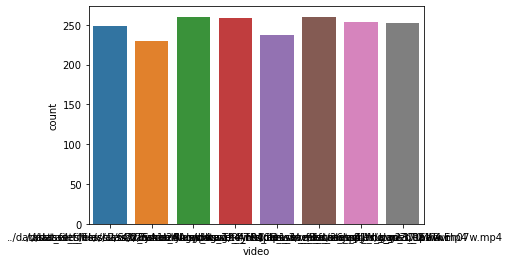

In [23]:
import seaborn as sns
sns.countplot(data=df, x='video')

In [33]:
class KineticsSequentialDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, frame_transform=None, video_transform=None, clip_len=16, alpha=0.1):
        super(KineticsSequentialDataset).__init__()
        
        self.samples = get_samples(root)
         
        # allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size
        
        self.clip_len = clip_len  # length of a clip in frames
        self.frame_transform = frame_transform  # transform for every frame individually
        self.video_transform = video_transform # transform on a video sequence
        # FIXME: maybe remove
        self.alpha = alpha # tollerance to avoid rounding errros with max seek time

    def __iter__(self):
        for i in range(len(self.samples)):
            # get random sample
            path, target = self.samples[i]
            # get video object
            vid = Video(path, debug=False)
             
            # seek and return frames
            num_steps = self.epoch_size // len(self.samples)
            max_seek = vid.metadata[vid.current_stream]['duration'] - (self.clip_len / vid.metadata[vid.current_stream]['fps'] + self.alpha)
            step = max(max_seek // num_steps, 1)
            tss = [i.item() for i in list(torch.linspace(0, max_seek, steps=num_steps))]
            for start in tss:
                video_frames = [] # video frame buffer
                vid.seek(start, stream="video", any_frame=True)
                while len(video_frames) < self.clip_len:
                    frame, current_pts, stream_t = vid.next("video")
                    video_frames.append(self.frame_transform(frame))
                # stack it into a tensor
                video = torch.stack(video_frames, 0)
                if self.video_transform:
                    video = self.video_transform(video)
                output = {
                    'path': path,
                    'video': video,
                    'target': target,
                    'start': start,
                    'end': current_pts}
                yield output

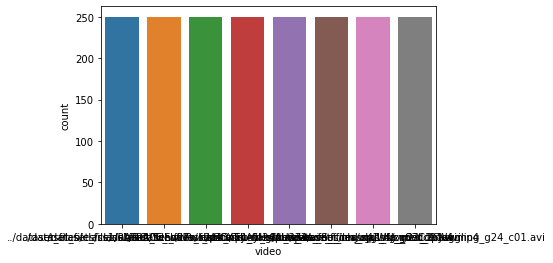

In [34]:
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = KineticsSequentialDataset("../dataset_files/", epoch_size=2000, frame_transform=frame_transform)
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=12)
d = {"video":[], 'start':[], 'end':[]}
for b in loader:
    for i in range(len(b['path'])):
        d['video'].append(b['path'][i])
        d['start'].append(b['start'][i].item())
        d['end'].append(b['end'][i].item())

import pandas as pd
df = pd.DataFrame.from_dict(d)
df.head()
        
import seaborn as sns
sns.countplot(data=df, x='video')

In [14]:
import os
import random

import torch
from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t

from video import Video


class AVADataset(torch.utils.data.IterableDataset):
    def __init__(self, root, annotation_file, clip_len=16, frame_transform=None, video_transform=None, frame_position="beginning"):
        super(AVADataset).__init__()
        self._preprocess_dataset(annotation_file)  # get dataset file
        self.clip_len = clip_len
        self.root=root
        self.frame_transform=frame_transform
        self.video_transform = video_transform
        assert frame_position in ["beginning", "middle"], "Keyframe can be either in the middle or at the beginning of the clip"
        self.fp = frame_position
        
    def _preprocess_dataset(self, annotation_file):
        df = pd.read_csv(annotation_file, names=["video_id", "middle_frame_timestamp", "x1", "y1", "x2", "y2", "action_id", "person_id"])
        # aggregate the actions/bounding-boxes according to have a list
        # of each for each video
        
        self.df = (df.groupby(['video_id', 'middle_frame_timestamp'], as_index=False)
      .agg(lambda x: list(x))).reset_index(drop=True)
        
    def __iter__(self):
        for idx in range(len(self.df)):
            video_id = self.df.video_id.loc[idx]
            start = self.df.middle_frame_timestamp.loc[idx]
            path = glob(os.path.join(self.root, video_id+"*"))[0]
            
            vid = Video(path, debug=False)
            video_frames = [] # video frame buffer
            
            if self.fp != "beginning":
                # FIXME: this is approximate situation
                fps = vid.metadata[vid.current_stream]['fps']
                start = max(0, start - float((self.clip_len // 2) * fps))

            vid.seek(start, stream="video", any_frame=True)
            while len(video_frames) < self.clip_len:
                frame, current_pts, stream_t = vid.next("video")
                video_frames.append(self.frame_transform(frame))
            
            # stack it into a tensor
            video = torch.stack(video_frames, 0)
            if self.video_transform:
                video = self.video_transform(video)
            output = {
                    'path': path,
                    'video': video,
#                     'x1': self.df.x1.loc[idx],
#                     'y1': self.df.y1.loc[idx],
#                     'x2': self.df.x2.loc[idx],
#                     'y2': self.df.y2.loc[idx],
#                     'action_id': self.df.action_id.loc[idx],
                    'person_id': self.df.person_id.loc[idx],
            }
            yield output
                

            
    

In [15]:
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)

ds = AVADataset("/work/bjuncek/AVA_actions/data/train/", "/work/bjuncek/AVA_actions/ava_train_v2.2.csv", 16, frame_transform=frame_transform )

In [13]:
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=1)
for b in loader:
    print(b)
    break

{'path': ['/work/bjuncek/AVA_actions/data/train/-5KQ66BBWC4.mkv'], 'video': tensor([[[[[0.0235, 0.0235, 0.0314,  ..., 0.0392, 0.0392, 0.0431],
           [0.0275, 0.0314, 0.0353,  ..., 0.0627, 0.0588, 0.0627],
           [0.0392, 0.0392, 0.0431,  ..., 0.0667, 0.0549, 0.0588],
           ...,
           [0.2549, 0.3255, 0.3176,  ..., 0.3176, 0.3176, 0.3451],
           [0.2745, 0.3176, 0.3176,  ..., 0.3490, 0.3569, 0.3882],
           [0.2824, 0.2549, 0.2627,  ..., 0.3020, 0.3059, 0.3137]],

          [[0.0431, 0.0431, 0.0392,  ..., 0.0588, 0.0627, 0.0706],
           [0.0471, 0.0471, 0.0431,  ..., 0.0824, 0.0824, 0.0941],
           [0.0588, 0.0549, 0.0510,  ..., 0.0980, 0.0902, 0.1020],
           ...,
           [0.4235, 0.5020, 0.5098,  ..., 0.4784, 0.4667, 0.4784],
           [0.4275, 0.4863, 0.5020,  ..., 0.5059, 0.4980, 0.5098],
           [0.4275, 0.4118, 0.4431,  ..., 0.4588, 0.4471, 0.4392]],

          [[0.0196, 0.0196, 0.0196,  ..., 0.0353, 0.0353, 0.0431],
           [0.023

# Keyframes dataset

In [23]:
import os
import random

import torch
from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t

from video import Video

def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def get_samples(root, extensions=(".mp4", ".avi")):
    _, class_to_idx = _find_classes(root)
    return make_dataset(root, class_to_idx, extensions=extensions)

class KFDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, transform=None, clip_len=16):
        super(KFDataset).__init__()
        
        self.samples = get_samples(root)
         
        # allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size
        
        self.clip_len = clip_len  # length of a clip in frames
        self.transform = frame_transform  # transform for every frame individually
    
    def __iter__(self):
        for i in range(self.epoch_size):
            path, target = random.choice(self.samples)
            # get video object
            vid = Video(path, debug=False)
            if vid.metadata[vid.current_stream]['duration'] > 0:
                start = random.uniform(0., vid.metadata[vid.current_stream]['duration'])
            else:
                start = random.uniform(0., 3600) # duration is an hour
            # seek only to keyframes
            vid.seek(start, stream="video", any_frame=False)
            frame, current_pts, stream_t = vid.next("video")
            if self.transform:
                frame = self.transform(frame)
                
            output = {
                    'path': path,
                    'video': frame,
                    'target': target
            }
            yield output

In [25]:
ds = KFDataset("../dataset_files/", transform=frame_transform)
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=2)
for b in loader:
    print(b['video'].size())

torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
